In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train['first_payment_date'] = train['first_payment_date'].replace({'02/2012':'Feb-12','03/2012':'Mar-12','04/2012':'Apr-12','05/2012':'May-12'})

In [4]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,May-12,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,Mar-12,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,Mar-12,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,Apr-12,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,Apr-12,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [6]:
train_original = train.copy()
test_original = test.copy()

<Figure size 432x288 with 0 Axes>

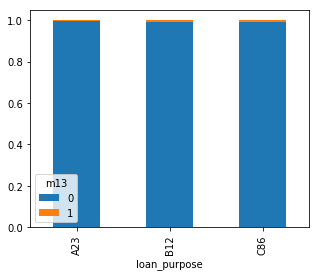

In [7]:
plt.figure(1)
source=pd.crosstab(train['loan_purpose'],train['m13'])
source.div(source.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(5,4))

In [8]:
source_mapping = {'X': 1, 'Y': 2, 'Z': 3,}
train['source'] = train['source'].map(source_mapping)
test['source'] = test['source'].map(source_mapping)

In [9]:
loan_purpose_mapping = {'A23':1,'B12':2,'C86':3}
train['loan_purpose'] = train['loan_purpose'].map(loan_purpose_mapping)
test['loan_purpose'] = test['loan_purpose'].map(loan_purpose_mapping)

In [10]:
train_hot_encoded = pd.get_dummies(train['financial_institution'])
test_hot_encoded = pd.get_dummies(test['financial_institution'])

In [11]:
train_hot_encoded_month = pd.get_dummies(train['first_payment_date'])
test_hot_encoded_month = pd.get_dummies(test['first_payment_date'])

In [12]:
new_train = pd.concat([train,train_hot_encoded,train_hot_encoded_month],axis=1)
new_test = pd.concat([test,test_hot_encoded,test_hot_encoded_month],axis=1)

In [13]:
new_train = new_train.drop(['loan_id','financial_institution','origination_date','first_payment_date'],axis=1)
new_test = new_test.drop(['loan_id','financial_institution','origination_date','first_payment_date'],axis=1)

In [14]:
data = new_train.drop('m13',axis=1)

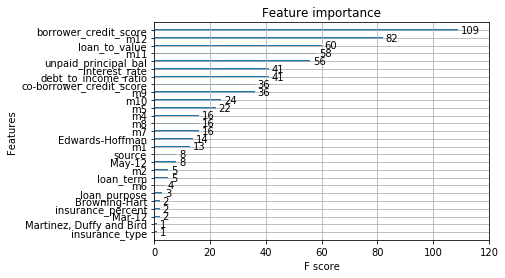

In [15]:
from xgboost import plot_importance
# fit model no training data
model = XGBClassifier()
model.fit(data, new_train['m13'])
# plot feature importance
plot_importance(model)
pyplot.show()

In [16]:
train_data = data[['borrower_credit_score','m12','m11','loan_to_value','unpaid_principal_bal','interest_rate','m9','debt_to_income_ratio','co-borrower_credit_score','m10', 'Apr-12', 'Feb-12',
       'Mar-12', 'May-12']]
test_data = new_test[['borrower_credit_score','m12','m11','loan_to_value','unpaid_principal_bal','interest_rate','m9','debt_to_income_ratio','co-borrower_credit_score','m10', 'Apr-12', 'Feb-12',
       'Mar-12', 'May-12']]

In [17]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data,new_train['m13'], test_size =0.3)

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27, ratio=0.5)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

In [80]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
x_train_std=sc.fit_transform(x_train)
x_cv_std=sc.transform(x_cv)

In [68]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train_std, y_train_res)
pred_cv = model.predict(x_cv_std)
print(round(accuracy_score(y_cv,pred_cv)*100 ,2))

c:\users\bal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


94.06


In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_cv, pred_cv).ravel()

array([32622,  1997,    70,   129], dtype=int64)

In [70]:
f1_score(y_cv, pred_cv, average='binary')

0.11096774193548387

In [71]:
from sklearn import tree
decisiontree = tree.DecisionTreeClassifier()
decisiontree.fit(x_train_std, y_train_res)
y_pred = decisiontree.predict(x_cv_std)

In [72]:
confusion_matrix(y_cv, y_pred).ravel()

array([34367,   252,   134,    65], dtype=int64)

In [73]:
f1_score(y_cv, y_pred, average='binary')

0.25193798449612403

In [53]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_cv)

c:\users\bal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [86]:
randomforest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
confusion_matrix(y_cv, y_pred).ravel()

array([34591,    28,   132,    67], dtype=int64)

In [55]:
f1_score(y_cv, y_pred, average='binary')

0.4557823129251701

In [85]:
randomfor = RandomForestClassifier()
randomfor.fit(x_train_std, y_train)
y_pred_std = randomfor.predict(x_cv_std)
confusion_matrix(y_cv, y_pred_std).ravel()

c:\users\bal\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([34594,    25,   132,    67], dtype=int64)

In [81]:
f1_score(y_cv, y_pred_std, average='binary')

0.4761904761904763

In [82]:
pred_test = randomfor.predict(test_data)

In [83]:
import collections
collections.Counter(pred_test)

Counter({0: 35796, 1: 70})

In [65]:
submission = pd.read_csv('sample_submission.csv')

In [66]:
submission['m13']=pred_test
submission['loan_id']=test_original['loan_id']
pd.DataFrame(submission, columns=['loan_id','m13']).to_csv('final_submission1.csv')

In [76]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = cross_val_score(randomfor, x_train_std, y_train_res, cv=3)
predictions = cross_val_predict(randomfor, x_train_std, y_train_res, cv=3)
f1_score(y_train_res, predictions, average='binary')

0.9916660447297062

In [87]:
from sklearn.model_selection import RandomizedSearchCV

In [88]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [91]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [92]:
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(x_train_std, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [93]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'